# Import Packages

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib
matplotlib.use('Agg')
%matplotlib inline

import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
from torch.autograd import Variable
import torch.optim as optim

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

# Basic Data Preparation

In [2]:
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')

dataset = pd.read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)

# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'

A quick check reveals NA values for pm2.5 for the first 24 hours. We will therefore need to remove the first row of data. There are also a few scattered “NA” values later in the dataset; we can mark them with 0 values for now.

In [3]:
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


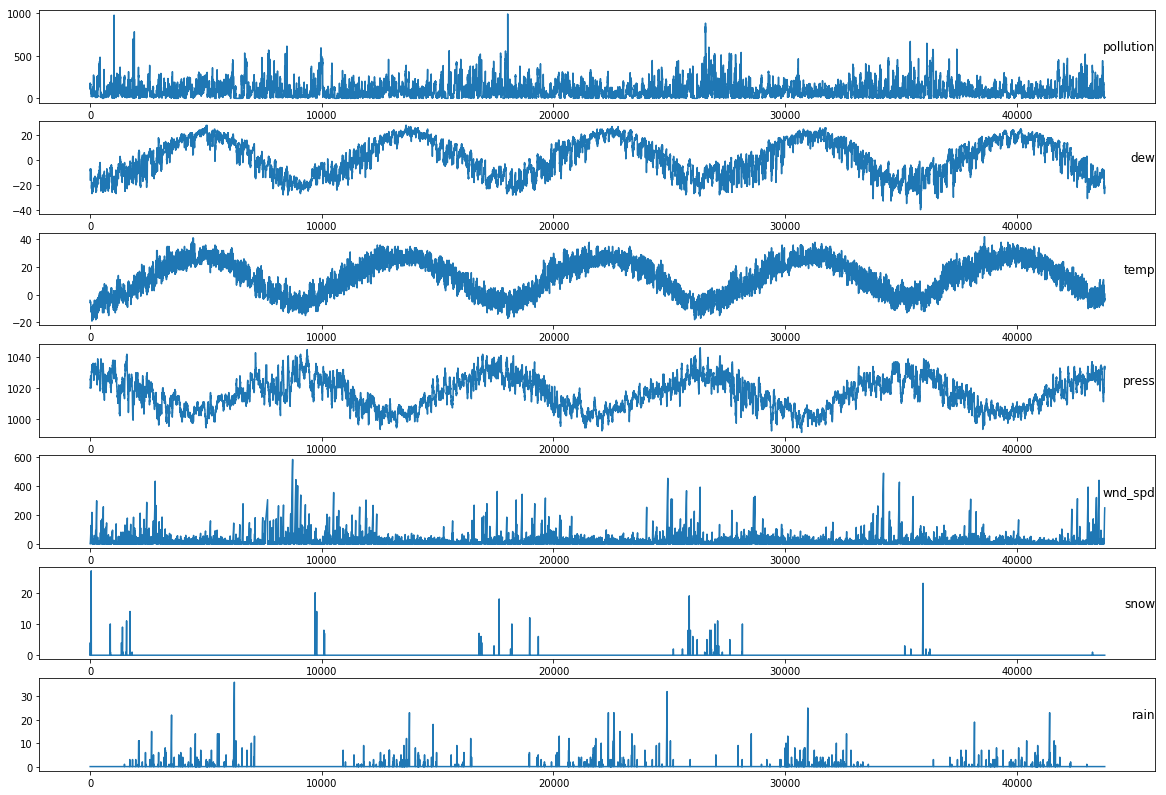

In [24]:
import matplotlib.pyplot as plt

# load dataset
# dataset = pd.read_csv('pollution.csv', header=0, index_col=0)

# np.array(dataset)
values = dataset.values

# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1

# plot each column
plt.figure(figsize=(20, 14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

# Multivariate LSTM Forecast Model

In this section, we will fit an LSTM to the problem.

## LSTM Data Preparation
First, the “pollution.csv” dataset is loaded. The wind speed feature is label encoded (integer encoded). This could further be one-hot encoded in the future if you are interested in exploring it.

Next, all features are normalized, then the dataset is transformed into a supervised learning problem. The weather variables for the hour to be predicted (t) are then removed.

In [43]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
# dataset = read_csv('pollution.csv', header=0, index_col=0)
# values = dataset.values

This data preparation is simple and there is more we could explore. Some ideas you could look at include:

- One-hot encoding wind speed.
- Making all series stationary with differencing and seasonal adjustment.
- Providing more than 1 hour of input time steps.

This last point is perhaps the most important given the use of Backpropagation through time by LSTMs when learning sequence prediction problems.

In [12]:
values = dataset.values
print(values[:,4])

encoder = LabelEncoder()
set(encoder.fit_transform(values[:,4]))

['SE' 'SE' 'SE' ..., 'NW' 'NW' 'NW']


{0, 1, 2, 3}

In [10]:
print(values[:,4])

['SE' 'SE' 'SE' ..., 'NW' 'NW' 'NW']


In [45]:
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)

print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002290   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003811   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005332   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008391   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.009912   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


## Split training and testing sets

First, we must split the prepared dataset into train and test sets. To speed up the training of the model for this demonstration, we will only fit the model on the first year of data, then evaluate it on the remaining 4 years of data. If you have time, consider exploring the inverted version of this test harness.

The example below splits the dataset into train and test sets, then splits the train and test sets into input and output variables. Finally, the inputs (X) are reshaped into the 3D format expected by LSTMs, namely [samples, timesteps, features].

Running this example prints the shape of the train and test input and output sets with about 9K hours of data for training and about 35K hours for testing.

```
(8760, 1, 8) (8760,) (35039, 1, 8) (35039,)
```

In [114]:
data = reframed.values

n_split = 365 * 24
# n_split = int(0.3 * len(data))
print(n_split)

train_X = Variable(torch.from_numpy(data[n_split:, :-1]), requires_grad=False)
train_y = Variable(torch.from_numpy(data[n_split:, 1:]), requires_grad=False)
test_X = Variable(torch.from_numpy(data[:n_split, :-1]), requires_grad=False)
test_y = Variable(torch.from_numpy(data[:n_split, 1:]), requires_grad=False)

print(train_X.size(), train_y.size(), test_X.size(), test_y.size())

8760
torch.Size([35039, 8]) torch.Size([35039, 8]) torch.Size([8760, 8]) torch.Size([8760, 8])


## Define the Model

In this section, we will fit an LSTM on the multivariate input data.

We will define the LSTM with 50 neurons in the first hidden layer and 1 neuron in the output layer for predicting pollution. The input shape will be 1 time step with 8 features.

We will use the Mean Absolute Error (MAE) loss function and the efficient Adam version of stochastic gradient descent.

The model will be fit for 50 training epochs with a batch size of 72.

> Remember that the internal state of the LSTM in Keras is reset at the end of each batch, so an internal state that is a function of a number of days may be helpful (try testing this).

Finally, we keep track of both the training and test loss during training by setting the validation_data argument in the fit() function. At the end of the run both the training and test loss are plotted.

In [108]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 1)

    def forward(self, input, future=0):
        outputs = []
        h_t = Variable(
            torch.zeros(input.size(0), 51), requires_grad=False)
        c_t = Variable(
            torch.zeros(input.size(0), 51), requires_grad=False)
        h_t2 = Variable(
            torch.zeros(input.size(0), 1), requires_grad=False)
        c_t2 = Variable(
            torch.zeros(input.size(0), 1), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]

        for i in range(future):  # if we should predict the future
            h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs
    

## Train and Evaluation

After the model is fit, we can forecast for the entire test dataset.

We combine the forecast with the test dataset and invert the scaling. We also invert scaling on the test dataset with the expected pollution numbers.

With forecasts and actual values in their original scale, we can then calculate an error score for the model. In this case, we calculate the Root Mean Squared Error (RMSE) that gives error in the same units as the variable itself.

In [116]:
# build the model
seq = Sequence()
# seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.Adam(seq.parameters())

loss_list = []
test_loss_list = []

epoch_num = 50

# begin to train
for epoch in range(epoch_num):
    print('epoch : ', epoch)

    def closure():
        optimizer.zero_grad()
        out = seq(train_X)
        loss = criterion(out, train_y)
#         print('loss:', loss.data.numpy()[0])
        loss_list.append(loss.data.numpy()[0])
        loss.backward()
        return loss

    optimizer.step(closure)

#   # begin to predict
#     future = 1000
#     pred = seq(test_X, future=future)
    pred = seq(test_X)
    loss = criterion(pred, test_y)
#     print('test loss:', loss.data.numpy()[0])
    test_loss_list.append(loss.data.numpy()[0])

    y = pred.data.numpy()

epoch :  0
epoch :  1
epoch :  2
epoch :  3
epoch :  4
epoch :  5
epoch :  6
epoch :  7
epoch :  8
epoch :  9
epoch :  10
epoch :  11
epoch :  12
epoch :  13
epoch :  14
epoch :  15
epoch :  16
epoch :  17
epoch :  18
epoch :  19
epoch :  20
epoch :  21
epoch :  22
epoch :  23
epoch :  24
epoch :  25
epoch :  26
epoch :  27
epoch :  28
epoch :  29
epoch :  30
epoch :  31
epoch :  32
epoch :  33
epoch :  34
epoch :  35
epoch :  36
epoch :  37
epoch :  38
epoch :  39
epoch :  40
epoch :  41
epoch :  42
epoch :  43
epoch :  44
epoch :  45
epoch :  46
epoch :  47
epoch :  48
epoch :  49


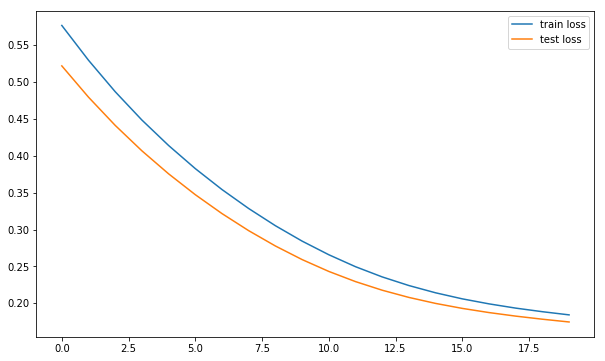

In [110]:
plt.figure(figsize=(10,6))
plt.plot(range(epoch_num), loss_list, label='train loss')
plt.plot(range(epoch_num), test_loss_list, label='test loss')
plt.legend()

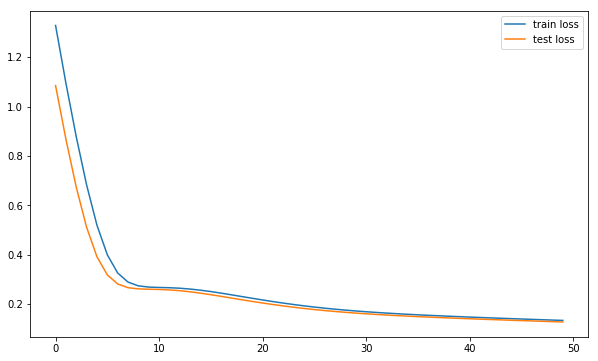

In [117]:
plt.figure(figsize=(10,6))
plt.plot(range(epoch_num), loss_list, label='train loss')
plt.plot(range(epoch_num), test_loss_list, label='test loss')
plt.legend()
plt.savefig('50iters-2.png', dpi=200)

# Another Example on Github

https://github.com/pytorch/examples/blob/master/time_sequence_prediction/train.py

In [2]:
# load data and make training set
# data = torch.load('traindata.pt')
import math
import numpy as np
import torch
T = 20
L = 1000
N = 100
np.random.seed(2)
x = np.empty((N, L), 'int64')
x[:] = np.array(range(L)) + np.random.randint(-4*T, 4*T, N).reshape(N, 1)
data = np.sin(x / 1.0 / T).astype('float64')

In [11]:
# # n_train_hours = 365 * 24
# n_split = int(0.3 * len(data))
n_split = 3

train_X = Variable(torch.from_numpy(data[n_split:, :-1]), requires_grad=False)
train_y = Variable(torch.from_numpy(data[n_split:, 1:]), requires_grad=False)
test_X = Variable(torch.from_numpy(data[:n_split, :-1]), requires_grad=False)
test_y = Variable(torch.from_numpy(data[:n_split, 1:]), requires_grad=False)

## 15 iterations - LBFGS

In [29]:
class Sequence(nn.Module):
    def __init__(self):
        super(Sequence, self).__init__()
        self.lstm1 = nn.LSTMCell(1, 51)
        self.lstm2 = nn.LSTMCell(51, 1)

    def forward(self, input, future=0):
        outputs = []
        h_t = Variable(
            torch.zeros(input.size(0), 51).double(), requires_grad=False)
        c_t = Variable(
            torch.zeros(input.size(0), 51).double(), requires_grad=False)
        h_t2 = Variable(
            torch.zeros(input.size(0), 1).double(), requires_grad=False)
        c_t2 = Variable(
            torch.zeros(input.size(0), 1).double(), requires_grad=False)

        for i, input_t in enumerate(input.chunk(input.size(1), dim=1)):
            h_t, c_t = self.lstm1(input_t, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]

        for i in range(future):  # if we should predict the future
            h_t, c_t = self.lstm1(c_t2, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(c_t, (h_t2, c_t2))
            outputs += [c_t2]

        outputs = torch.stack(outputs, 1).squeeze(2)
        return outputs


# build the model
seq = Sequence()
seq.double()
criterion = nn.MSELoss()

# use LBFGS as optimizer since we can load the whole data to train
optimizer = optim.LBFGS(seq.parameters())

# begin to train
for i in range(15):
    print('STEP: ', i)

    def closure():
        optimizer.zero_grad()
        out = seq(train_X)
        loss = criterion(out, train_y)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss

    optimizer.step(closure)

    # begin to predict
    future = 1000
    pred = seq(test_X, future=future)
    loss = criterion(pred[:, :-future], test_y)
    print('test loss:', loss.data.numpy()[0])

    y = pred.data.numpy()

STEP:  0
loss: 0.636314103437
loss: 0.543004249708
loss: 0.235352960269
loss: 0.0999996266652
loss: 0.101607921475
loss: 0.0455085120477
loss: 0.0369889140201
loss: 0.0308598667305
loss: 0.0283142141265
loss: 0.0257547576527
loss: 0.0248603209342
loss: 0.0226814830733
loss: 0.0194109053017
loss: 0.0158258644403
loss: 0.0128798467173
loss: 0.0106140999058
loss: 0.00952109408852
loss: 0.00809584609916
loss: 0.00754954088281
loss: 0.00652695765136
test loss: 0.00580555213871
STEP:  1
loss: 0.00599252606313
loss: 0.00531235435919
loss: 0.00497799229402
loss: 0.00466899457865
loss: 0.0040517183937
loss: 0.00444502672216
loss: 0.00353034627871
loss: 0.00329467030611
loss: 0.0029625981474
loss: 0.00238967619112
loss: 0.00634182643846
loss: 0.00185736415467
loss: 0.00150002877826
loss: 0.000821910571174
loss: 0.00148726305044
loss: 0.000503418417599
loss: 0.000439889727096
loss: 0.000405566857012
loss: 0.000402664985792
loss: 0.000400334890186
test loss: 0.000345330529445
STEP:  2
loss: 0.0003

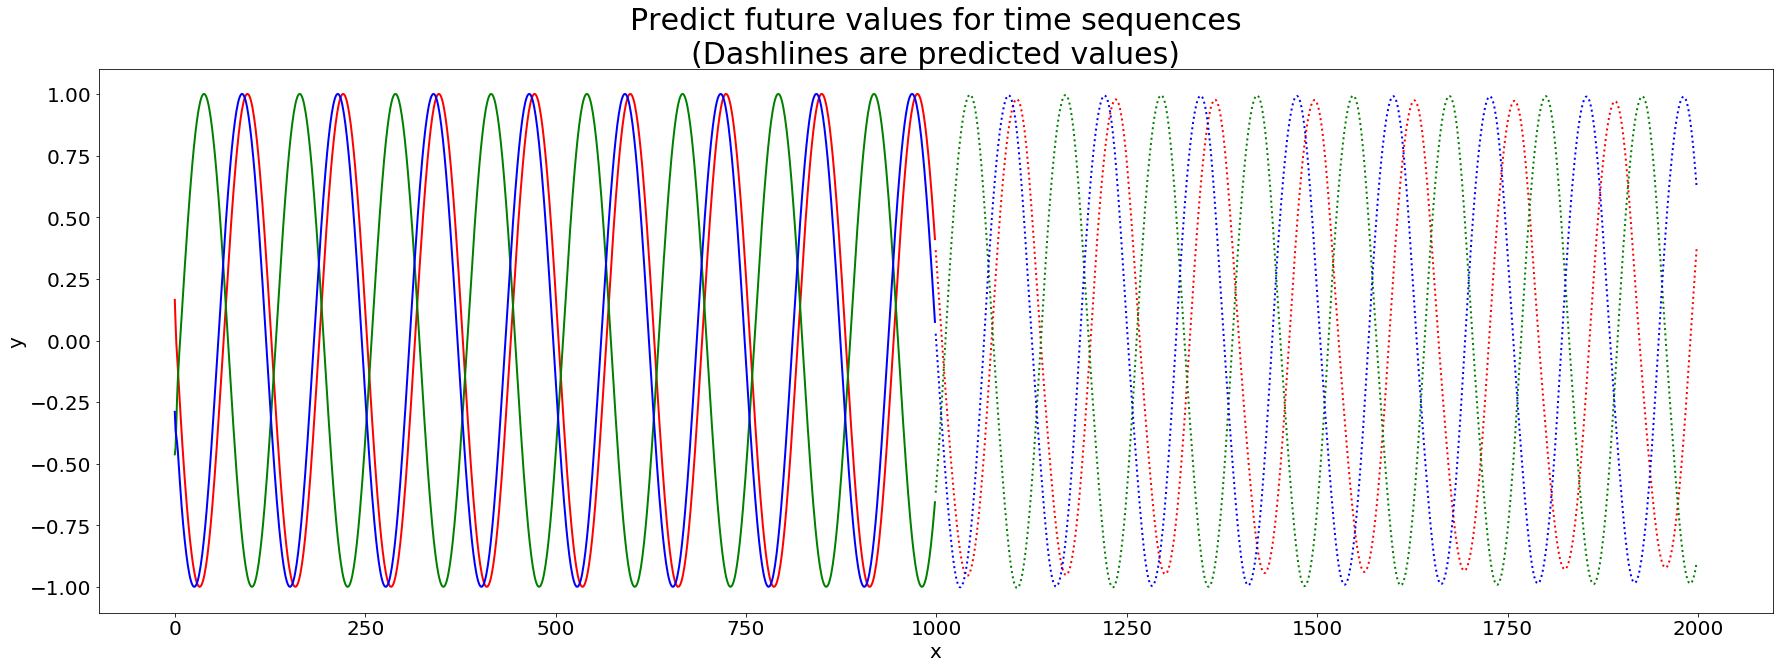

In [30]:
# draw the result
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30) 
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(train_X.size(1)), yi[:train_X.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(train_X.size(1), train_X.size(1) + future), yi[train_X.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
# plt.savefig('predict%d.png'%i)
plt.show()
plt.close()

## 5 iterations - LBFGS

In [31]:
# begin to train
for i in range(5):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(train_X)
        loss = criterion(out, train_y)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    # begin to predict
    future = 1000
    pred = seq(test_X, future = future)
    loss = criterion(pred[:, :-future], test_y)
    print('test loss:', loss.data.numpy()[0])
    
    y = pred.data.numpy()

STEP:  0
loss: 1.95015765412e-05
loss: 1.9445722018e-05
loss: 1.93594960777e-05
loss: 1.9285867806e-05
loss: 1.91929585004e-05
loss: 1.92090194374e-05
loss: 1.93376649991e-05
loss: 1.91326570413e-05
loss: 1.90395302601e-05
loss: 1.89933130806e-05
loss: 1.89072267772e-05
loss: 1.87790294571e-05
loss: 1.87149380932e-05
loss: 1.8700042832e-05
loss: 1.86881077222e-05
loss: 1.86819690743e-05
loss: 1.86736959369e-05
loss: 1.86641391883e-05
loss: 1.86535420867e-05
loss: 1.86476404607e-05
test loss: 1.93451897412e-05
STEP:  1
loss: 1.86445114144e-05
loss: 1.86419057722e-05
loss: 1.86333958157e-05
loss: 1.86189897042e-05
loss: 1.85977321124e-05
loss: 1.85825045458e-05
loss: 1.85860379322e-05
loss: 1.85665718152e-05
loss: 1.85624762265e-05
loss: 1.85520782404e-05
loss: 1.85408357151e-05
loss: 1.84969263692e-05
loss: 1.84467318822e-05
loss: 1.86643298449e-05
loss: 1.83141428668e-05
loss: 1.82214221857e-05
loss: 1.84281513229e-05
loss: 1.86052480622e-05
loss: 1.89318056362e-05
loss: 1.83486803149e

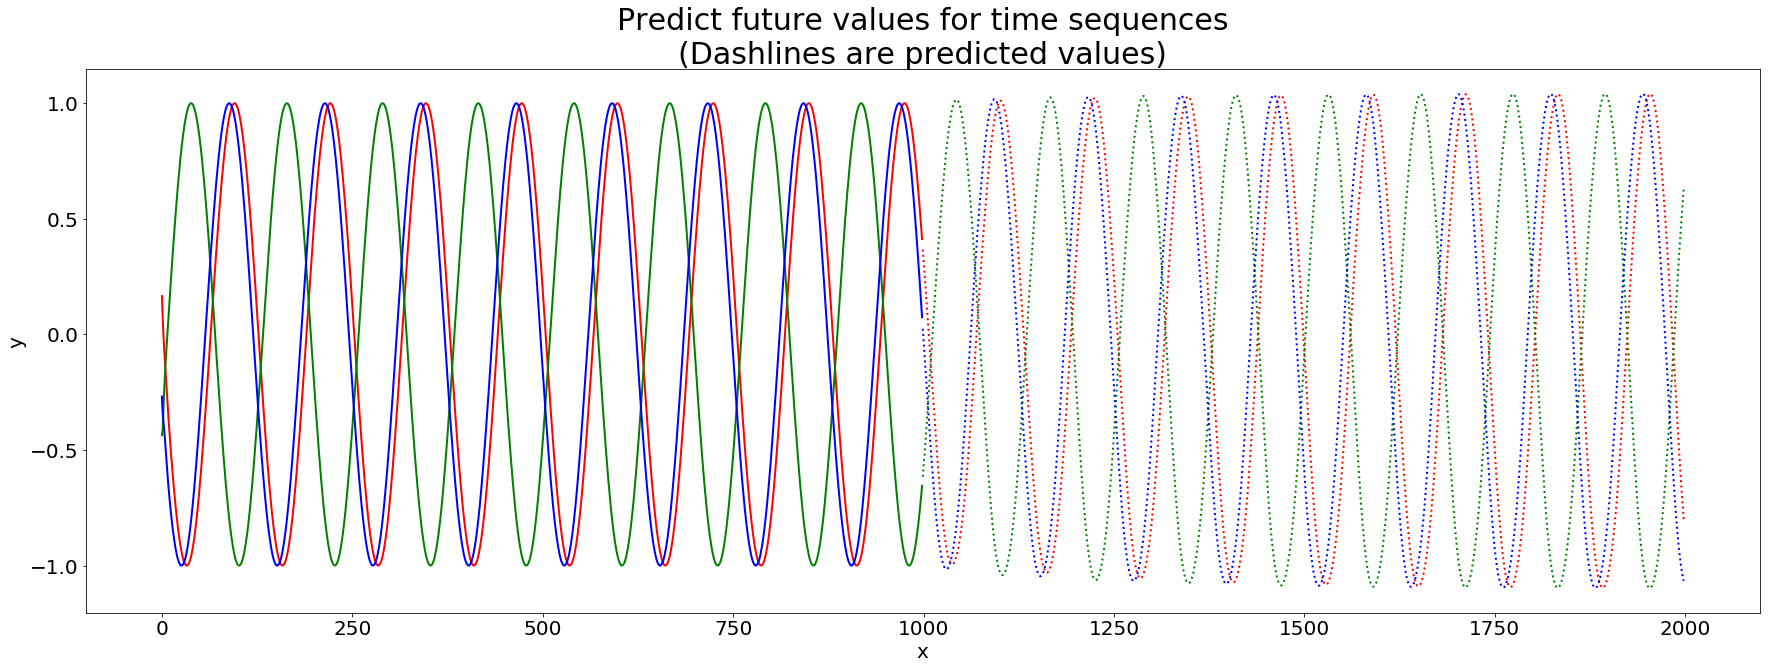

In [33]:
# draw the result
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30) 
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(train_X.size(1)), yi[:train_X.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(train_X.size(1), train_X.size(1) + future), yi[train_X.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
# plt.savefig('predict%d.pdf'%i)
# plt.close()
plt.show()

## 5 iterations - Adam

In [34]:
optimizer = optim.Adam(seq.parameters())
# begin to train
for i in range(5):
    print('STEP: ', i)
    def closure():
        optimizer.zero_grad()
        out = seq(train_X)
        loss = criterion(out, train_y)
        print('loss:', loss.data.numpy()[0])
        loss.backward()
        return loss
    
    optimizer.step(closure)
    
    # begin to predict
    future = 1000
    pred = seq(test_X, future = future)
    loss = criterion(pred[:, :-future], test_y)
    print('test loss:', loss.data.numpy()[0])
    
    y = pred.data.numpy()

STEP:  0
loss: 1.71057596323e-05
test loss: 0.0259267271002
STEP:  1
loss: 0.0258106195434
test loss: 0.043235221025
STEP:  2
loss: 0.0432727850221
test loss: 0.0064649094428
STEP:  3
loss: 0.00645282936685
test loss: 0.0130834708038
STEP:  4
loss: 0.0130572282334
test loss: 0.0277040228826


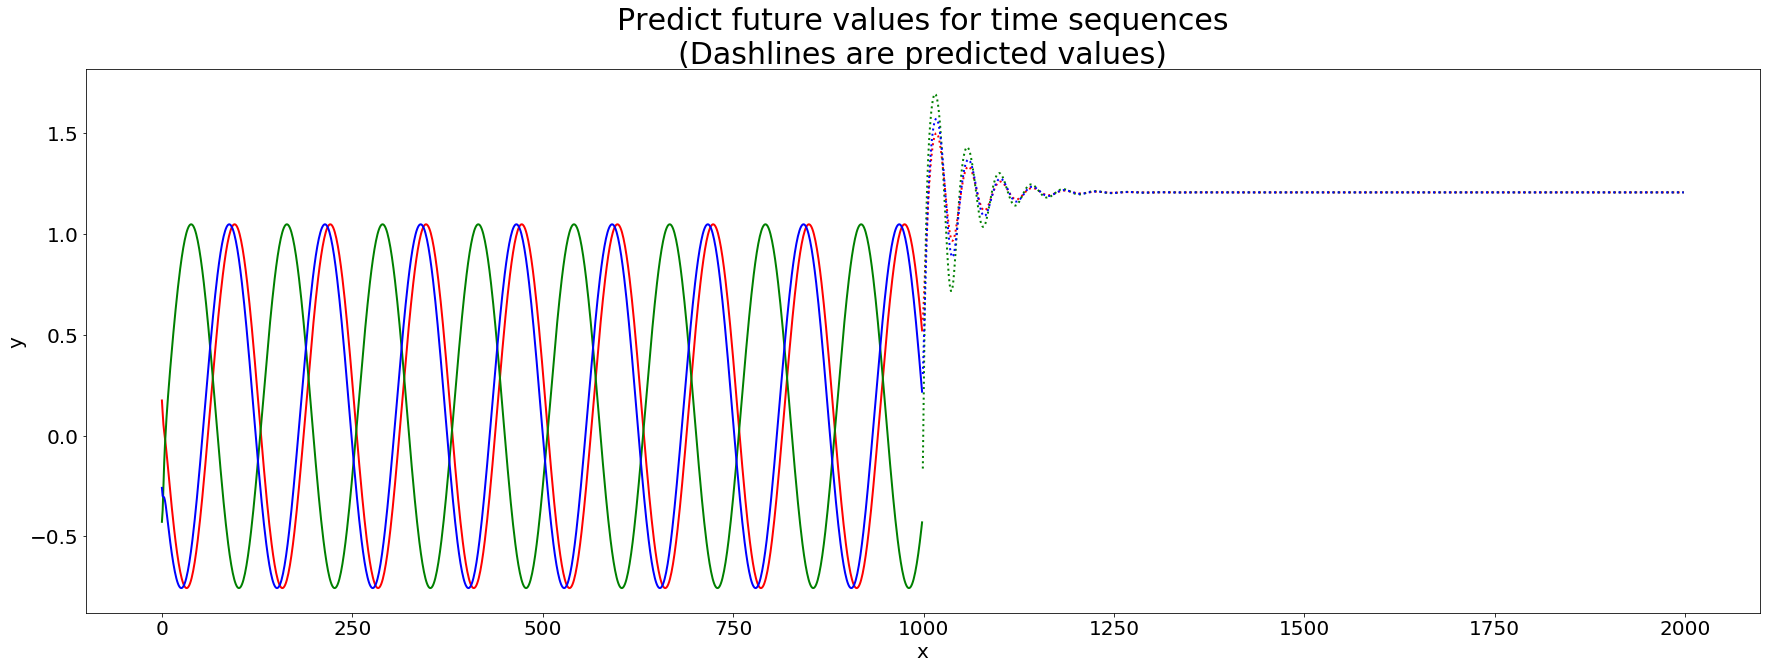

In [35]:
# draw the result
plt.figure(figsize=(30,10))
plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30) 
plt.xlabel('x', fontsize=20)
plt.ylabel('y', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
def draw(yi, color):
    plt.plot(np.arange(train_X.size(1)), yi[:train_X.size(1)], color, linewidth = 2.0)
    plt.plot(np.arange(train_X.size(1), train_X.size(1) + future), yi[train_X.size(1):], color + ':', linewidth = 2.0)
draw(y[0], 'r')
draw(y[1], 'g')
draw(y[2], 'b')
# plt.savefig('predict%d.pdf'%i)
# plt.close()
plt.show()